# Train and Test Models

#### Classification models:
In order to get a perspective of the preformance we can achive, we tried using the following models:
- Logistic Regression
- KNN
- SVM
- Decision Tree
- Random Forest
- Neural Network
- LSTM model
- All models ensemble

All predictions are written into csv files at the end of the process.

#### Draw class:
As we saw on our first attempt classifier, the classifier never chose the draw class, to deal with this issue we had te drop/duplicate some samples in order to get same amount of samples for each class. 



#### General Impotrs:

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import pickle
import random
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA

#### Functions:
The functions below will drop/duplicate samples from our db in order to make it balanced (i.e same amount of samples for each class).

In [2]:
def drop_samples(features,labels,random_state=None):
    min_samples = labels["win_lose_draw"].value_counts().min()
    rr = []
    for label in  labels["win_lose_draw"].unique():
        ee = list(labels[labels["win_lose_draw"] == label].index)
        random.seed(random_state)
        random.shuffle(ee)
        rr = rr + ee[min_samples:]
        
    return features.drop(rr), labels.drop(rr)
        
def duplicate_samples(features,labels,random_state=None):
    max_samples = labels["win_lose_draw"].value_counts().max()
    rr = []
    for label in labels["win_lose_draw"].unique():
        ee = list(labels[labels["win_lose_draw"] == label].index)
        sam_to_add = max_samples - len(ee)
        dd = ee.copy()
        random.seed(random_state)
        random.shuffle(dd)
        rr = rr + ee + dd[:sam_to_add]
        
    return features.loc[rr], labels.loc[rr]

This function will split the data randomly (using specific seed) according to seasons. Split mode (according to season/100% random) is selected in the Hyperparameters box.

In [3]:
def split_data_according_season(features, labels, test_size,random_state=None):
    X_train = {}
    X_test = {}
    y_train = {}
    y_test = {}
    
    all_seasons = features["season"].unique()
    all_leagues = features["league"].unique()
    
    num_of_seasons    = len(all_seasons)
    test_num_seasons  = round(num_of_seasons*test_size)
    train_num_seasons = num_of_seasons-test_num_seasons
        
    for league in all_leagues:
        random.seed(random_state)
        random.shuffle(all_seasons)

        train_seasons = all_seasons[:train_num_seasons]
        test_seasons  = all_seasons[train_num_seasons:]

        printmd('**' + league + ':**')
        print("train_leagues =",train_seasons)
        print("test_leagues  =",test_seasons)

        X_train[league] = features[(features["league"] == league) & (features["season"].isin(train_seasons))]
        X_test[league]  = features[(features["league"] == league) & (features["season"].isin(test_seasons))]
        y_train[league] = labels[(labels["league"] == league) & (labels["season"].isin(train_seasons))]
        y_test[league]  = labels[(labels["league"] == league) & (labels["season"].isin(test_seasons))]
    
    aa = pd.concat(X_train)
    aa.index = aa.index.droplevel()
    bb = pd.concat(X_test)
    bb.index = bb.index.droplevel()
    cc = pd.concat(y_train)
    cc.index = cc.index.droplevel()
    dd = pd.concat(y_test)
    dd.index = dd.index.droplevel()
    
    return aa,bb,cc,dd

In [4]:
def get_split_func(split_mode):
    return {
        "according_season": split_data_according_season,
        "default":          train_test_split
    }.get(split_mode,train_test_split)

def get_balance_samples_func(split_mode):
    return {
        "drop":      drop_samples,
        "duplicate": duplicate_samples
    }.get(split_mode,drop_samples)

Visualization of soft decision for our 3 classes (dimension reduction from 3D to 2D using pca):

In [5]:
def plot_soft_decision_plan(model_name,model_predictions,real_labels):
    X = np.array([[1,0,0],[0,1,0],[0,0,1]])
    pca = PCA(n_components=2)
    pca.fit(X)

    tt = pca.transform(model_predictions)
    df = pd.DataFrame(tt,index=real_labels.index)
    df["real_labels"] = real_labels
    df["predictions"] = pd.Series(model_predictions.argmax(axis=1),index=real_labels.index)

    fig, (ax1, ax2) = plt.subplots(figsize = (20, 6), ncols = 2, sharey = True)
    fig.suptitle("Model name = " + model_name,fontsize=22)
    ax1.set_title("Real Labels", fontsize = 18)
    ax2.set_title("Predictions", fontsize = 18)
    
    colors = {0:'red', 1:'blue', 2:'green'}

    grouped = df.groupby('real_labels')
    for key, group in grouped:
        group.plot(ax=ax1, kind='scatter', x=0, y=1, label=key, color=colors[key])
        
    grouped = df.groupby('predictions')
    for key, group in grouped:
        group.plot(ax=ax2, kind='scatter', x=0, y=1, label=key, color=colors[key])

    plt.show()

In [6]:
def save_obj(obj, name ):
    with open('databases/objects/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('databases/objects/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def printmd(string):
    display(Markdown(string))

#### Read all DB's:

In [7]:
current_leagues = ["England_Premier_League","France_Ligue_1","Germany_1._Bundesliga","Netherlands_Eredivisie","Spain_LIGA_BBVA"]

#Availible Leagues:
#"England_Premier_League","France_Ligue_1","Germany_1._Bundesliga","Netherlands_Eredivisie","Spain_LIGA_BBVA"

#Not Availible Leagues (yet):
#Italy_Serie_A/Switzerland_Super_League

In [8]:
window_size = load_obj("window_size")

In [9]:
basic_info       = ["index","league","season","stage","home_team_name","away_team_name","score"]
betting_odds     = ["B365H","WHH","VCH","B365A","WHA","VCA","B365D","WHD","VCD"]
last_games_wld   = [str(x)+"_last_wld" for x in list(range(1,window_size))]
window_features  = [str(x)+"_pos_goals" for x in list(range(2,window_size))]+[str(x)+"_neg_goals" for x in list(range(2,window_size))]+[str(x)+"_wins" for x in list(range(2,window_size))]+[str(x)+"_loses" for x in list(range(2,window_size))]+[str(x)+"_draws" for x in list(range(2,window_size))]
new_features     = ["points","norm_points","position","straight_wins","straight_loses","straight_draws","tot_pos_goals","tot_neg_goals","goals_diff"] + window_features# + last_games_wld
important_info   = basic_info + ["home_team_goal","away_team_goal"]

percent_per_season_columns = ["home_win_season_percent","home_lose_season_percent","home_draw_season_percent","away_win_season_percent","away_lose_season_percent","away_draw_season_percent"]
percent_total_columns      = ["home_win_percent","home_lose_percent","home_draw_percent","away_win_percent","away_lose_percent","away_draw_percent"]

home_away        = ["home","away"]

new_columns      = important_info + betting_odds

new_new_columns  = []

for r in itertools.product(home_away,new_features): new_new_columns.append(r[0] +"_"+ r[1])

In [10]:
features_list = new_new_columns + percent_per_season_columns + percent_total_columns + betting_odds# + ["stage"]
labels_list   = "win_lose_draw"

In [11]:
final_matches_db = pd.read_csv("databases/my_matches_db.csv", encoding='latin-1', index_col = [0])

In [12]:
all_leagues = final_matches_db["league"].unique()

for league in all_leagues:
    if league.replace(" ","_") in current_leagues: continue
    final_matches_db = final_matches_db[final_matches_db["league"] != league]

In [13]:
final_matches_db.reset_index(inplace=True)
final_matches_db.dropna(axis = 0,inplace=True)

In [14]:
final_matches_db

,index,league,season,stage,home_team_name,away_team_name,score,home_points,home_norm_points,home_position,...,B365H,WHH,VCH,B365A,WHA,VCA,B365D,WHD,VCD,win_lose_draw
40,40,England Premier League,2008/2009,5,Liverpool,Stoke City,0 - 0,10.0,1.000000,2.0,...,1.20,1.20,1.20,15.00,15.00,17.00,6.50,6.00,6.50,0
41,41,England Premier League,2008/2009,5,Sunderland,Middlesbrough,2 - 0,4.0,0.400000,17.0,...,2.38,2.30,2.25,3.20,3.20,3.35,3.10,3.20,3.30,1
42,42,England Premier League,2008/2009,5,Tottenham Hotspur,Wigan Athletic,0 - 0,1.0,0.100000,20.0,...,1.73,1.70,1.70,5.00,5.50,5.50,3.60,3.40,3.60,0
43,43,England Premier League,2008/2009,5,West Ham United,Newcastle United,3 - 1,6.0,0.600000,8.0,...,2.10,2.00,2.00,3.60,3.80,3.80,3.30,3.30,3.50,1
44,44,England Premier League,2008/2009,5,Manchester City,Portsmouth,6 - 0,6.0,0.600000,7.0,...,2.00,2.00,2.05,4.00,3.80,3.80,3.30,3.30,3.35,1
45,45,England Premier League,2008/2009,5,Blackburn Rovers,Fulham,1 - 0,4.0,0.400000,18.0,...,2.10,2.10,2.05,3.60,3.50,3.75,3.30,3.30,3.40,1
46,46,England Premier League,2008/2009,5,Bolton Wanderers,Arsenal,1 - 3,4.0,0.400000,14.0,...,6.50,6.00,6.20,1.57,1.62,1.60,3.75,3.60,3.80,2
47,47,England Premier League,2008/2009,5,West Bromwich Albion,Aston Villa,1 - 2,4.0,0.400000,15.0,...,3.25,2.90,3.30,2.25,2.40,2.25,3.30,3.30,3.35,2
48,48,England Premier League,2008/2009,5,Hull City,Everton,2 - 2,7.0,0.700000,6.0,...,3.10,3.25,3.15,2.30,2.25,2.30,3.40,3.25,3.40,0
49,49,England Premier League,2008/2009,5,Chelsea,Manchester United,1 - 1,10.0,1.000000,1.0,...,2.20,2.20,2.20,3.60,3.60,3.70,3.10,3.00,3.10,0


#### Hyperparameters:
- Split mode selection: split according to season or 100% randomly.
- Balance data mode: drop or duplicate samples.
- Threshold for logistic regression (in order to increase number of "draw" predictions)

In [15]:
split_mode  = "according_season" #"default/according_season"
test_size   = 0.30
seed        = None #100

balance_mode = "drop" #drop/duplicate

threshold_1 = 1.5
threshold_2 = {1:0.45,2:0.35}

#### Split the data:

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
info_list = ["index","league","season","stage","home_team_name","away_team_name"]
features  = final_matches_db[info_list + features_list]
labels    = final_matches_db[info_list + [labels_list]]

In [18]:
print("Num of features =",len(features_list))

Num of features = 69


In [19]:
X_train_original, X_test_original, y_train_original, y_test_original = get_split_func(split_mode)(features, labels, test_size=test_size, random_state=seed)

**England Premier League:**

train_leagues = ['2015/2016' '2013/2014' '2009/2010' '2008/2009' '2011/2012' '2014/2015']
test_leagues  = ['2012/2013' '2010/2011']


**France Ligue 1:**

train_leagues = ['2008/2009' '2015/2016' '2009/2010' '2011/2012' '2013/2014' '2010/2011']
test_leagues  = ['2012/2013' '2014/2015']


**Germany 1. Bundesliga:**

train_leagues = ['2014/2015' '2012/2013' '2015/2016' '2010/2011' '2013/2014' '2009/2010']
test_leagues  = ['2008/2009' '2011/2012']


**Netherlands Eredivisie:**

train_leagues = ['2013/2014' '2014/2015' '2011/2012' '2015/2016' '2012/2013' '2009/2010']
test_leagues  = ['2008/2009' '2010/2011']


**Spain LIGA BBVA:**

train_leagues = ['2014/2015' '2010/2011' '2013/2014' '2015/2016' '2011/2012' '2012/2013']
test_leagues  = ['2008/2009' '2009/2010']


#### Balance the data:
We drop/duplicate samples only from the tarining data (in order to train our models on balanced data) while test data stay the same in order to maintain reality as much as we can.

In [20]:
printmd('**Before ' + balance_mode + ' samples:**')
print(y_train_original["win_lose_draw"].value_counts(),"\n")

X_train_original,y_train_original = get_balance_samples_func(balance_mode)(X_train_original,y_train_original,random_state=seed)

printmd('**After ' + balance_mode + ' samples:**')
print(y_train_original["win_lose_draw"].value_counts())

**Before drop samples:**

1    4347
2    2681
0    2320
Name: win_lose_draw, dtype: int64 



**After drop samples:**

2    2320
1    2320
0    2320
Name: win_lose_draw, dtype: int64


In [21]:
X_train_def = X_train_original[features_list]
X_test_def  = X_test_original[features_list]
y_train_def = y_train_original[labels_list]
y_test_def  = y_test_original[labels_list]

### Training:
We use some models for traing. We started with logistic regression model. All other model will follow.

####  Logistic Regression model

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
logmodel = LogisticRegression()

In [24]:
logmodel.fit(X_train_def,y_train_def)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
predictions = logmodel.predict(X_test_def)

#### Learning Evaluation:

In [26]:
from sklearn.metrics import classification_report,confusion_matrix

In [27]:
print(classification_report(y_test_def,predictions))

             precision    recall  f1-score   support

          0       0.30      0.41      0.34       786
          1       0.66      0.47      0.55      1484
          2       0.43      0.50      0.46       844

avg / total       0.51      0.46      0.47      3114



In [28]:
print(confusion_matrix(y_test_def,predictions))

[[319 209 258]
 [486 695 303]
 [276 145 423]]


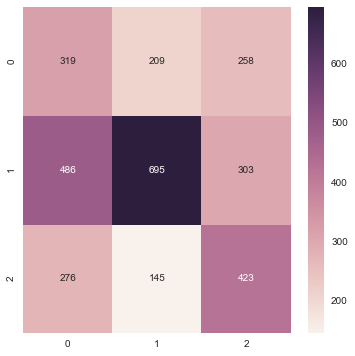

In [29]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test_def,predictions),annot=True, fmt="d")

In [30]:
coeff_df = pd.DataFrame(logmodel.coef_.T,features_list,
                        columns=['Coefficient_home','Coefficient_away','Coefficient_draw'])
coeff_df

,Coefficient_home,Coefficient_away,Coefficient_draw
home_points,0.022543,-0.008913,-0.016004
home_norm_points,0.556038,0.130652,-0.741929
home_position,0.027711,0.001896,-0.035742
home_straight_wins,-0.040661,0.037197,-0.005890
home_straight_loses,0.025485,-0.047132,0.011724
home_straight_draws,0.001637,0.002771,-0.004443
home_tot_pos_goals,-0.010858,0.005787,0.006184
home_tot_neg_goals,-0.004544,0.002762,0.002183
home_goals_diff,-0.006314,0.003025,0.004001
home_2_pos_goals,0.010242,-0.076762,0.065584


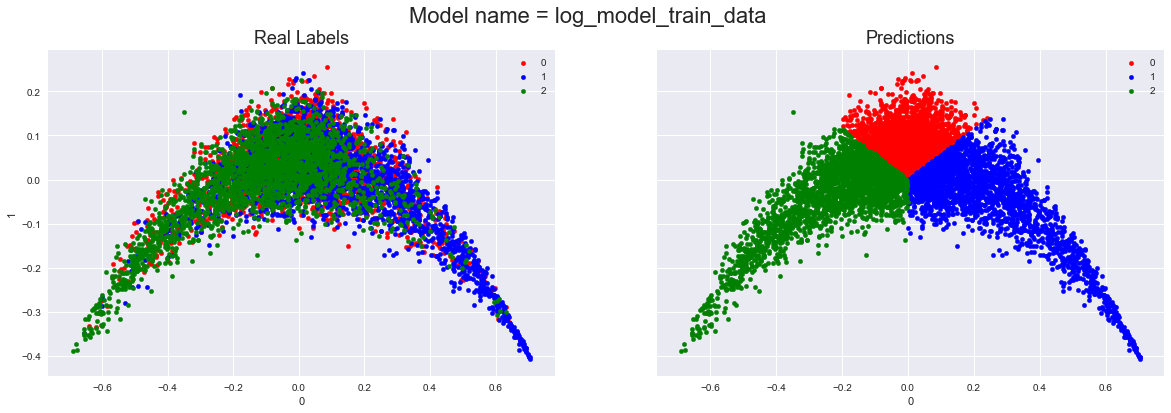

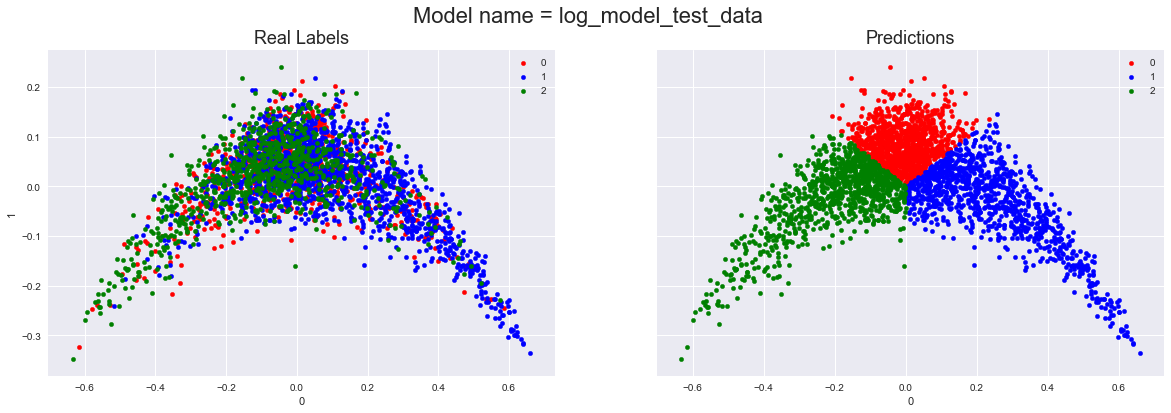

In [31]:
train_soft_decision = logmodel.predict_proba(X_train_def)
test_soft_decision  = logmodel.predict_proba(X_test_def)

plot_soft_decision_plan("log_model_train_data",train_soft_decision,y_train_original[labels_list])
plot_soft_decision_plan("log_model_test_data",test_soft_decision,y_test_original[labels_list])

In the plots above we can see the projection of all train and test samples soft decisions into 2D plan. Actually, this is "how the model see all samples" and decide the classify them.

The plot below show the ratio of predicted classes.

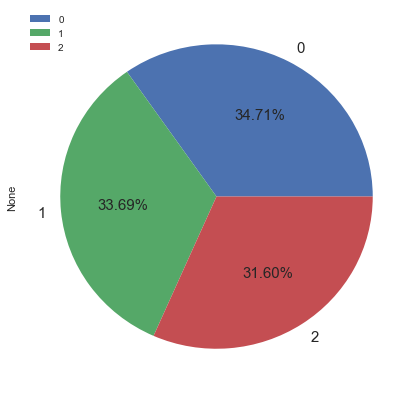

In [32]:
pd.Series(predictions).value_counts().plot.pie(figsize=(7, 7),legend=True,autopct='%.2f%%',fontsize=15)

#### Adding thresold to Logistic Regression model
This part is no longer in use. First we tried to maintain real classes ratio and it caused our models to predict "draw" very occasionally. That is why we added this threshold methods. Since we balanced our data we don't have to do so.

In [33]:
soft_decision = logmodel.predict_proba(X_test_def)

In [34]:
def thresh_1(probs,threshold):
    decision  = -1
    if max(probs) == probs[0]: decision = 0
    else:
        home_away_probs = list(probs[[1,2]])
        if max(home_away_probs) > threshold*min(home_away_probs): decision = (home_away_probs.index(max(home_away_probs)) + 1)
    if decision == -1: decision = 0
    return decision

def thresh_2(probs,threshold):
    decision  = -1
    if    probs[1] > threshold[1]: decision = 1
    elif  probs[2] > threshold[2]: decision = 2
    else:                          decision = 0
    return decision

In [35]:
new_predictions = {"threshold_1":[],"threshold_2":[]}

for aa in range(len(soft_decision)):
    new_predictions["threshold_1"].append(thresh_1(soft_decision[aa],threshold_1))
    new_predictions["threshold_2"].append(thresh_2(soft_decision[aa],threshold_2))

In [36]:
for thresh,prediction in new_predictions.items():
    printmd('**threshold = ' + thresh + '**')
    print(classification_report(y_test_def,prediction))
    print(confusion_matrix(y_test_def,prediction),"\n\n")

**threshold = threshold_2**

             precision    recall  f1-score   support

          0       0.28      0.49      0.36       786
          1       0.73      0.31      0.44      1484
          2       0.42      0.57      0.49       844

avg / total       0.54      0.43      0.43      3114

[[382 104 300]
 [668 461 355]
 [294  66 484]] 




**threshold = threshold_1**

             precision    recall  f1-score   support

          0       0.29      0.55      0.38       786
          1       0.69      0.39      0.50      1484
          2       0.48      0.43      0.45       844

avg / total       0.53      0.44      0.45      3114

[[432 159 195]
 [705 578 201]
 [376 105 363]] 




### Adding more models:

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### KNN:

In [38]:
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train_def,y_train_def)
    pred_i = knn.predict(X_test_def)
    error_rate.append(np.mean(pred_i != y_test_def))

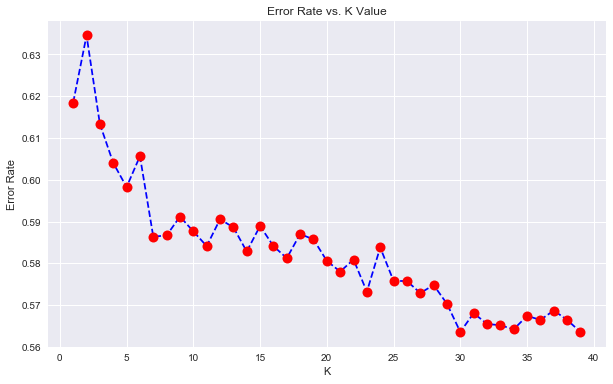

In [39]:
plt.figure(figsize = (10,6))
plt.plot(range(1,40), error_rate, color = 'blue', linestyle = 'dashed', marker = 'o',
         markerfacecolor = 'red', markersize = 10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [40]:
best_n_neighbors = error_rate.index(min(error_rate))+1
print("best_n_neighbors =",best_n_neighbors)

best_n_neighbors = 30


In [41]:
knn = KNeighborsClassifier(n_neighbors = best_n_neighbors)

#### SVM:

In [42]:
#svm_param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001]} 
#svm_grid   = GridSearchCV(SVC(), svm_param_grid, refit = True, verbose = 3)
#svm_grid.fit(X_train_def,y_train_def)
#svm = svm_grid.best_estimator_

In [43]:
svm = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
          decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
          max_iter=-1, probability=True, random_state=None, shrinking=True,
          tol=0.001, verbose=False)

#### Decision Tree:

In [44]:
#dtree_param_grid = {'max_depth': [5,6,7,8,9,10], 'min_samples_split': [6,7,8,9,10], 'min_samples_leaf': [2,3,4],'max_features':[10,20,30,40,50,None]} 
#dtree_grid   = GridSearchCV(DecisionTreeClassifier(), dtree_param_grid, refit = True, verbose = 3)
#dtree_grid.fit(X_train_def,y_train_def)
#dtree = dtree_grid.best_estimator_

In [45]:
dtree = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                               max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07,
                               min_samples_leaf=3, min_samples_split=9,
                               min_weight_fraction_leaf=0.0, presort=False, random_state=None,
                               splitter='best')

#### Random Forest:

In [46]:
#rfc_param_grid = {'max_depth': [5,6,7,8,9,10], 'min_samples_split': [6,7,8,9,10], 'min_samples_leaf': [2,3,4],'max_features':[10,20,30,40,50,None]} 
#rfc_grid   = GridSearchCV(RandomForestClassifier(n_estimators=10), rfc_param_grid, refit = True, verbose = 3)
#rfc_grid.fit(X_train_def,y_train_def)
#rfc = rfc_grid.best_estimator_

In [47]:
rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                             max_depth=6, max_features='auto', max_leaf_nodes=None,
                             min_impurity_split=1e-07, min_samples_leaf=4,
                             min_samples_split=6, min_weight_fraction_leaf=0.0,
                             n_estimators=600, n_jobs=1, oob_score=False, random_state=None,
                             verbose=0, warm_start=False)

### Train and Predict using all model:

In [48]:
all_models               = [knn,rfc,dtree,svm]

models_test_predictions  = {}
models_train_predictions = {}

for model in all_models:
    classifier_name = str(model).split("(")[0]
    model.fit(X_train_def,y_train_def)
    models_test_predictions[classifier_name]  = model.predict(X_test_def)
    models_train_predictions[classifier_name] = model.predict(X_train_def)

##### Test Data Reports:

In [49]:
printmd('**Test Data:**')

for model_name,model_prediction in models_test_predictions.items():
    printmd('**classifier = ' + model_name + '**')
    print(classification_report(y_test_def,model_prediction))
    print(confusion_matrix(y_test_def,model_prediction),"\n\n")

**Test Data:**

**classifier = KNeighborsClassifier**

             precision    recall  f1-score   support

          0       0.29      0.43      0.35       786
          1       0.64      0.44      0.52      1484
          2       0.40      0.43      0.42       844

avg / total       0.49      0.44      0.45      3114

[[341 207 238]
 [516 651 317]
 [324 153 367]] 




**classifier = SVC**

             precision    recall  f1-score   support

          0       0.30      0.49      0.37       786
          1       0.66      0.42      0.51      1484
          2       0.45      0.46      0.45       844

avg / total       0.51      0.45      0.46      3114

[[383 187 216]
 [595 624 265]
 [319 136 389]] 




**classifier = DecisionTreeClassifier**

             precision    recall  f1-score   support

          0       0.28      0.38      0.32       786
          1       0.67      0.42      0.51      1484
          2       0.41      0.55      0.47       844

avg / total       0.50      0.44      0.45      3114

[[300 188 298]
 [507 616 361]
 [262 118 464]] 




**classifier = RandomForestClassifier**

             precision    recall  f1-score   support

          0       0.31      0.50      0.38       786
          1       0.68      0.44      0.53      1484
          2       0.49      0.50      0.49       844

avg / total       0.53      0.47      0.48      3114

[[396 189 201]
 [590 650 244]
 [301 122 421]] 




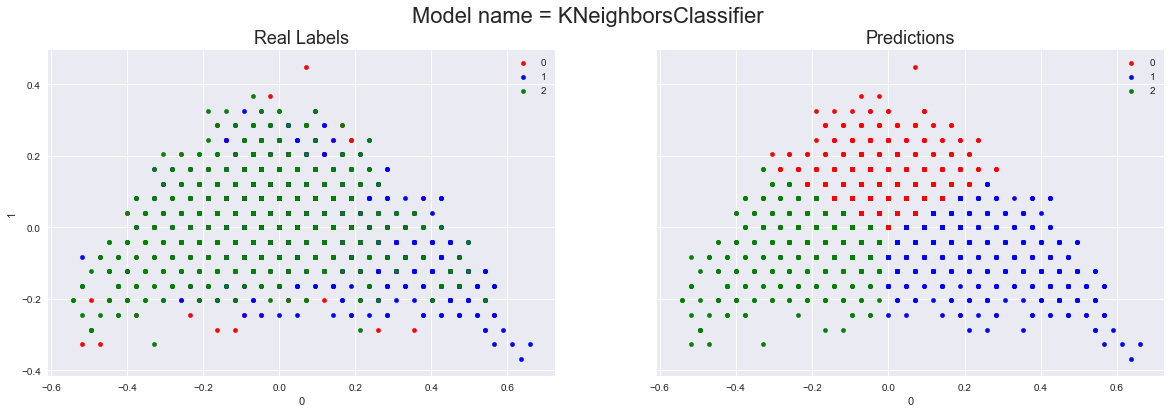

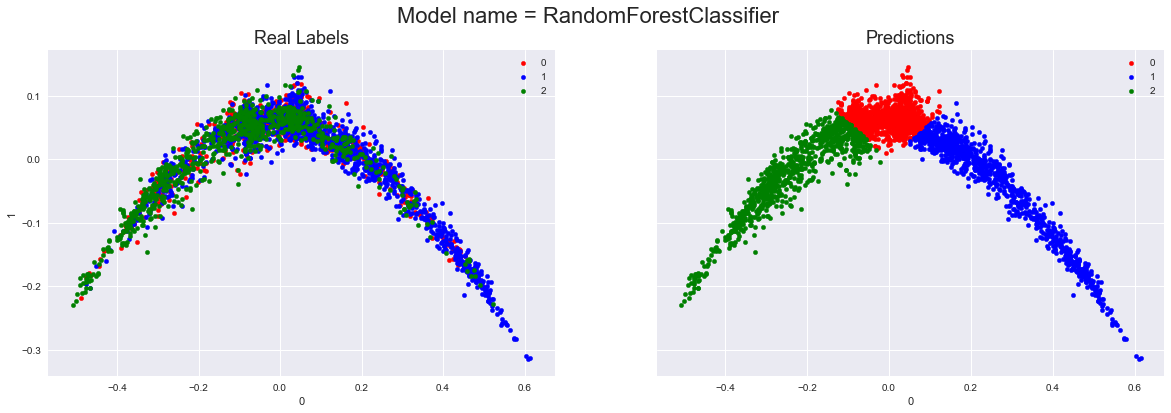

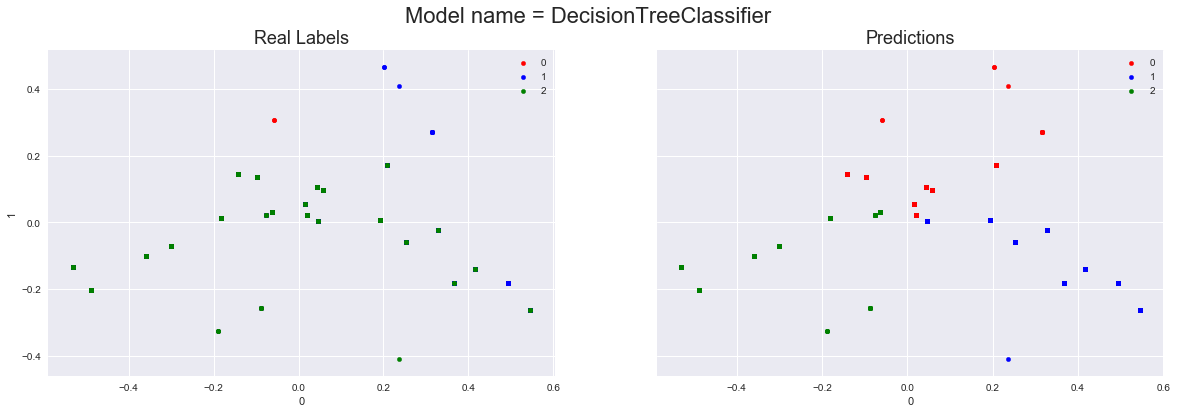

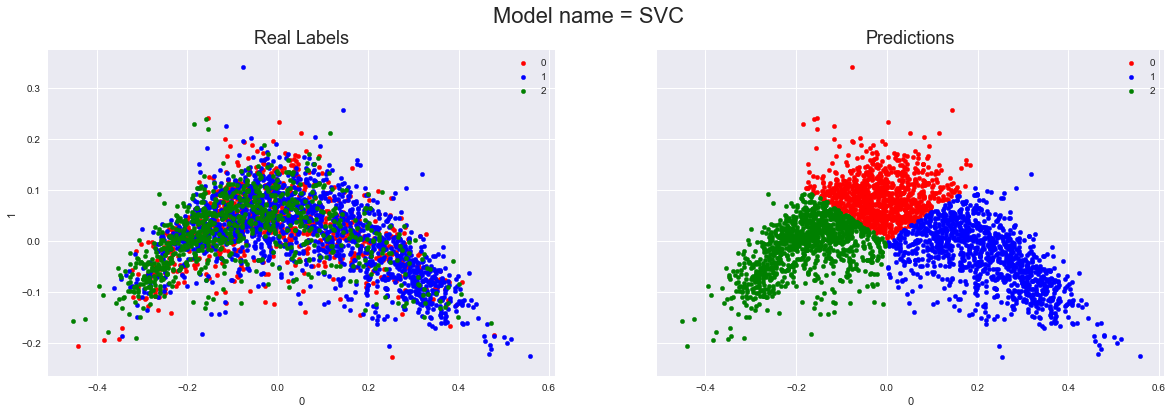

In [50]:
for model in all_models:
    classifier_name = str(model).split("(")[0]
    soft_dec = model.predict_proba(X_test_def)
    plot_soft_decision_plan(classifier_name,soft_dec,y_test_original[labels_list])

##### Train Data Reports:
We check train reports too in order to ensure we don't have overfitting.

In [51]:
printmd('**Train Data:**')

for model_name,model_prediction in models_train_predictions.items():
    printmd('**classifier = ' + model_name + '**')
    print(classification_report(y_train_def,model_prediction))
    print(confusion_matrix(y_train_def,model_prediction),"\n\n")

**Train Data:**

**classifier = KNeighborsClassifier**

             precision    recall  f1-score   support

          0       0.44      0.49      0.46      2320
          1       0.55      0.50      0.52      2320
          2       0.53      0.52      0.53      2320

avg / total       0.51      0.50      0.50      6960

[[1133  564  623]
 [ 722 1162  436]
 [ 721  396 1203]] 




**classifier = SVC**

             precision    recall  f1-score   support

          0       0.44      0.54      0.48      2320
          1       0.59      0.48      0.53      2320
          2       0.56      0.53      0.54      2320

avg / total       0.53      0.52      0.52      6960

[[1252  485  583]
 [ 817 1121  382]
 [ 789  306 1225]] 




**classifier = DecisionTreeClassifier**

             precision    recall  f1-score   support

          0       0.41      0.41      0.41      2320
          1       0.57      0.47      0.51      2320
          2       0.49      0.58      0.53      2320

avg / total       0.49      0.49      0.48      6960

[[ 940  524  856]
 [ 690 1081  549]
 [ 661  303 1356]] 




**classifier = RandomForestClassifier**

             precision    recall  f1-score   support

          0       0.44      0.54      0.49      2320
          1       0.58      0.50      0.54      2320
          2       0.59      0.54      0.56      2320

avg / total       0.54      0.53      0.53      6960

[[1260  525  535]
 [ 823 1156  341]
 [ 759  310 1251]] 




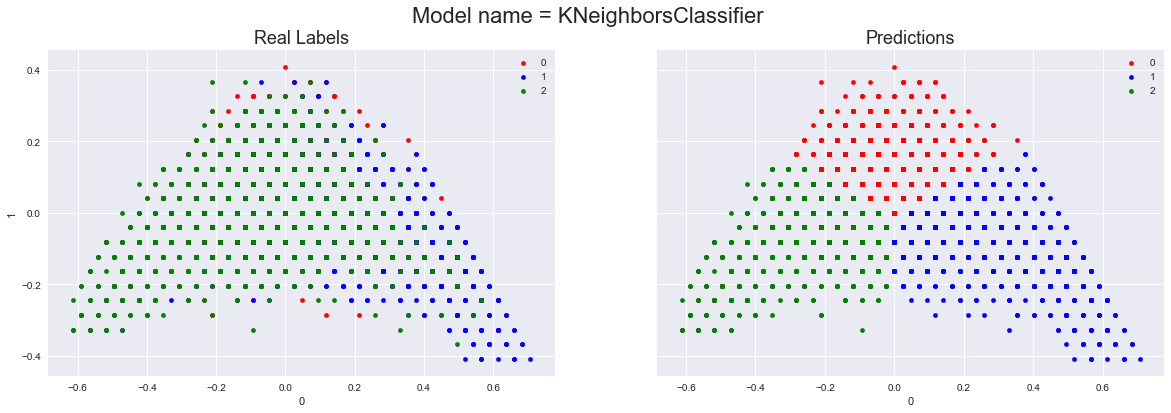

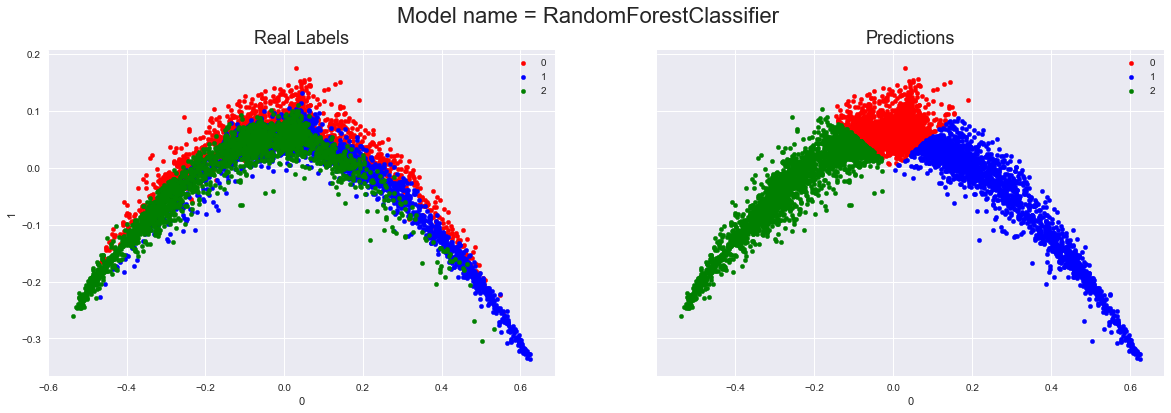

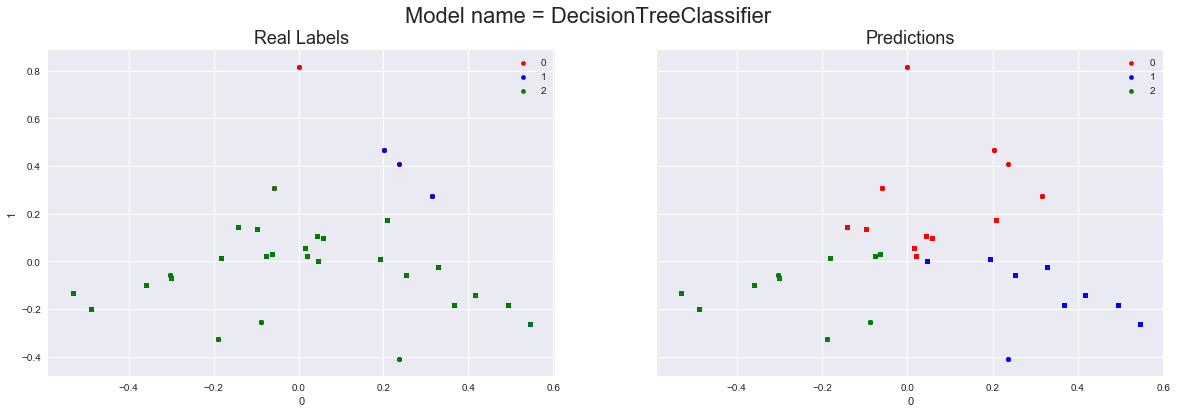

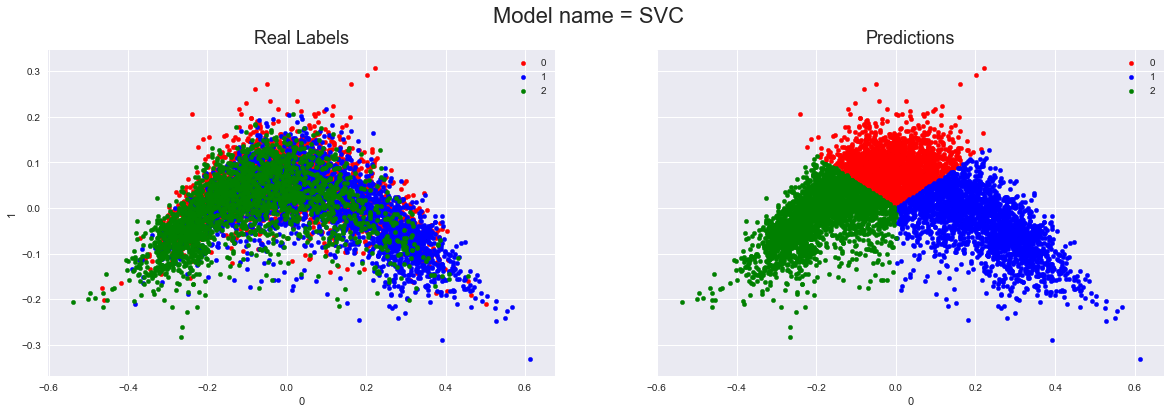

In [52]:
for model in all_models:
    classifier_name = str(model).split("(")[0]
    soft_dec = model.predict_proba(X_train_def)
    plot_soft_decision_plan(classifier_name,soft_dec,y_train_original[labels_list])

#### Nueral Network model:

In [53]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from sklearn import preprocessing
from keras.callbacks import EarlyStopping
from keras import regularizers
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

Using TensorFlow backend.


In [54]:
L   = [100,100,10]
dim = len(features_list)
k   = 3

nb_epoch   = 150
batch_size = 1500
dropout    = 0.5
regularization_factor = 0.01

X_train_mat = X_train_def.as_matrix()
X_test_mat  = X_test_def.as_matrix()
y_train_mat = y_train_def.as_matrix()
y_test_mat  = y_test_def.as_matrix()
Y_train_mat = np_utils.to_categorical(y_train_def, k)
Y_test_mat  = np_utils.to_categorical(y_test_def, k)

In [55]:
# normalizer = preprocessing.Normalizer().fit(X_train)
# X_train_norm = normalizer.transform(X_train)                            
# X_test_norm = normalizer.transform(X_test)    
X_train_mat.max()

117.0

In [56]:
nn_model = Sequential()
nn_model.add(Dense(L[0], input_dim=dim, init='normal', activation='relu'))
nn_model.add(Dropout(dropout))
for ii in range(1,len(L)):
    nn_model.add(Dense(L[ii], init='normal',kernel_regularizer=regularizers.l2(regularization_factor), activation='relu'))
    nn_model.add(Dropout(dropout))
nn_model.add(Dense(k, init='normal',kernel_regularizer=regularizers.l2(regularization_factor), activation='softmax'))
nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", input_dim=69, kernel_initializer="normal")`
  
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", kernel_initializer="normal", kernel_regularizer=<keras.reg...)`
  """
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal", kernel_regularizer=<keras.reg...)`
  """
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, activation="softmax", kernel_initializer="normal", kernel_regularizer=<keras.reg...)`
  import sys


In [57]:
nn_model.fit(X_train_mat, Y_train_mat, nb_epoch=nb_epoch, batch_size=batch_size,validation_data=(X_test_mat, Y_test_mat),shuffle=True, callbacks=[early_stopping])

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 6960 samples, validate on 3114 samples
Epoch 1/150
6960/6960 [==============================] - 3s - loss: 1.3730 - categorical_accuracy: 0.3366 - val_loss: 1.3389 - val_categorical_accuracy: 0.4942
Epoch 2/150
6960/6960 [==============================] - 0s - loss: 1.3305 - categorical_accuracy: 0.3614 - val_loss: 1.3062 - val_categorical_accuracy: 0.4583
Epoch 3/150
6960/6960 [==============================] - 0s - loss: 1.2952 - categorical_accuracy: 0.3812 - val_loss: 1.2717 - val_categorical_accuracy: 0.4672
Epoch 4/150
6960/6960 [==============================] - 0s - loss: 1.2625 - categorical_accuracy: 0.4047 - val_loss: 1.2371 - val_categorical_accuracy: 0.4759
Epoch 5/150
6960/6960 [==============================] - 0s - loss: 1.2317 - categorical_accuracy: 0.4011 - val_loss: 1.2002 - val_categorical_accuracy: 0.4965
Epoch 6/150
6960/6960 [==============================] - 0s - loss: 1.2033 - categorical_accuracy: 0.4108 - val_loss: 1.1660 - val_categorical_accuracy:

6960/6960 [==============================] - 0s - loss: 1.0378 - categorical_accuracy: 0.4636 - val_loss: 1.0382 - val_categorical_accuracy: 0.4631
Epoch 52/150
6960/6960 [==============================] - 0s - loss: 1.0357 - categorical_accuracy: 0.4674 - val_loss: 1.0318 - val_categorical_accuracy: 0.4724
Epoch 53/150
6960/6960 [==============================] - 0s - loss: 1.0389 - categorical_accuracy: 0.4602 - val_loss: 1.0414 - val_categorical_accuracy: 0.4602
Epoch 54/150
6960/6960 [==============================] - 0s - loss: 1.0325 - categorical_accuracy: 0.4647 - val_loss: 1.0293 - val_categorical_accuracy: 0.4730
Epoch 55/150
6960/6960 [==============================] - 0s - loss: 1.0349 - categorical_accuracy: 0.4631 - val_loss: 1.0311 - val_categorical_accuracy: 0.4746
Epoch 56/150
6960/6960 [==============================] - 0s - loss: 1.0380 - categorical_accuracy: 0.4658 - val_loss: 1.0360 - val_categorical_accuracy: 0.4621


In [58]:
final_predictions = nn_model.predict_classes(X_test_mat, verbose=1)
print(classification_report(y_test_mat,final_predictions))
print(confusion_matrix(y_test_mat,final_predictions))

2880/3114 [==========================>...] - ETA: 0s             precision    recall  f1-score   support

          0       0.27      0.29      0.28       786
          1       0.65      0.47      0.55      1484
          2       0.42      0.60      0.50       844

avg / total       0.50      0.46      0.47      3114

[[229 225 332]
 [415 700 369]
 [190 144 510]]


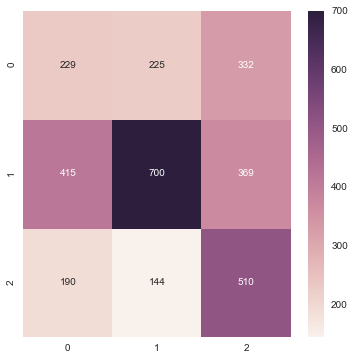

In [59]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test_mat,final_predictions),annot=True, fmt="d")

### LSTM:
Till now all models "looked" at each match separatly regardless to former matches. Now we will try to learn sequences of entire season for each team using LSTM model.

In [60]:
def func1(x,temp_dic,home_away,team):
    temp_dic[home_away]              = x.loc[(x[home_away + "_team_name"] == team)].copy()
    temp_dic[home_away]["home_away"] = home_away
    
def get_df(x,func,func_data):
    temp_dic = {}
    for home_away in ["home", "away"]:
        func(x,temp_dic,home_away,func_data)
    return temp_dic["home"].append(temp_dic["away"]).sort_values(["season","stage"])

In [61]:
new_matches_LSTM = final_matches_db
all_teams_LSTM   = final_matches_db["home_team_name"].unique()
all_seasons_LSTM = final_matches_db['season'].unique()

In [62]:
new_matches_LSTM.dropna(inplace=True)
num_total = []
for league in all_leagues:
    min_stage = new_matches_LSTM[new_matches_LSTM["league"] == league]["stage"].min()
    max_stage = new_matches_LSTM[new_matches_LSTM["league"] == league]["stage"].max()
    print("league =",league,", min_stage =",min_stage,", max_stage =",max_stage)
    num_of_stages    = max_stage - min_stage + 1
    num_total.append(num_of_stages)
num_total
max_stages = np.max(num_total)
num_of_features = len(features_list)

league = England Premier League , min_stage = 5 , max_stage = 38
league = France Ligue 1 , min_stage = 5 , max_stage = 38
league = Germany 1. Bundesliga , min_stage = 5 , max_stage = 34
league = Netherlands Eredivisie , min_stage = 5 , max_stage = 34
league = Spain LIGA BBVA , min_stage = 5 , max_stage = 38


In [63]:
def LSTM_matrix_league_pad(matches_LSTM,all_leagues,all_teams_LSTM,all_seasons_LSTM):
    label_league        = {}
    LSTM_matches_league = {}
    index_league        = {}
    min_stage           = float('inf')

    first_iter = True
    for league in all_leagues:
        for team in all_teams_LSTM:
            for season in all_seasons_LSTM:
                matches_per_team        = get_df(matches_LSTM[matches_LSTM['league']==league],func1,team)
                matches_per_team_season = matches_per_team[matches_per_team["season"] == season].copy()
                if len(matches_per_team_season.index) == 0: continue
                temp = matches_per_team_season.dropna(axis = 0)

                matches_temp = temp['index'].as_matrix()
                matches_temp = np.expand_dims(matches_temp, axis=0)

                labels_temp     = temp['win_lose_draw'].as_matrix()
                labels_temp_bin = np_utils.to_categorical(labels_temp, k)
                labels_temp_bin = np.expand_dims(labels_temp_bin, axis=0)

                features_temp               = temp[features_list]
                matches_per_team_season_mat = features_temp.as_matrix()
                matches_per_team_season_mat = np.expand_dims(matches_per_team_season_mat, axis=0)

                if first_iter:
                    if np.shape(matches_per_team_season_mat)[1] != max_stages:
                        
                        columns_to_fill = max_stages - np.shape(matches_per_team_season_mat)[1]
                        features_pad    = np.zeros([1,columns_to_fill,num_of_features])
                        matches_per_team_season_mat = np.concatenate((matches_per_team_season_mat,features_pad),axis = 1)

                        label_pad       = np.zeros([1,columns_to_fill])
                        label_pad       = np_utils.to_categorical(label_pad, k)
                        label_pad       = np.expand_dims(label_pad, axis=0)
                        labels_temp_bin = np.concatenate((labels_temp_bin,label_pad),axis = 1)
                        
                        index_pad    = np.ones([1,columns_to_fill])*(-1)
                        matches_temp = np.concatenate((matches_temp,index_pad),axis = 1)
                        
                    label_league[league]        = labels_temp_bin
                    LSTM_matches_league[league] = matches_per_team_season_mat
                    index_league[league]        = matches_temp
                    first_iter                  = False

                else:
                    if np.shape(matches_per_team_season_mat)[1] != max_stages:
                        columns_to_fill = max_stages - np.shape(matches_per_team_season_mat)[1]
                        features_pad    = np.zeros([1,columns_to_fill,num_of_features])
                        matches_per_team_season_mat = np.concatenate((matches_per_team_season_mat,features_pad),axis = 1)
                        
                        label_pad       = np.zeros([1,columns_to_fill])
                        label_pad       = np_utils.to_categorical(label_pad, k)
                        label_pad       = np.expand_dims(label_pad, axis=0)
                        labels_temp_bin = np.concatenate((labels_temp_bin,label_pad),axis = 1)
                        
                        index_pad    = np.ones([1,columns_to_fill])*(-1)
                        matches_temp = np.concatenate((matches_temp,index_pad),axis = 1)
                    
                    LSTM_matches_league[league] = np.concatenate((LSTM_matches_league[league], matches_per_team_season_mat), axis=0)
                    label_league[league] = np.concatenate((label_league[league], labels_temp_bin), axis=0)
                    index_league[league] = np.concatenate((index_league[league], matches_temp), axis=0)
        print(league,np.shape(LSTM_matches_league[league]))
        min_stage = min(min_stage,np.shape(LSTM_matches_league[league])[1])
        first_iter = True
        
    return (LSTM_matches_league,label_league,index_league,min_stage)

In [64]:
train_matches = pd.concat([X_train_original,y_train_original['win_lose_draw']], axis=1)
test_matches  = pd.concat([X_test_original,y_test_original['win_lose_draw']], axis=1)

LSTM_matches_league_train_pad,label_league_train_pad,index_league_train_pad,min_stage_train_pad = LSTM_matrix_league_pad(train_matches,all_leagues,all_teams_LSTM,all_seasons_LSTM)
LSTM_matches_league_test_pad,label_league_test_pad,index_league_test_pad,min_stage_test_pad     = LSTM_matrix_league_pad(test_matches,all_leagues,all_teams_LSTM,all_seasons_LSTM)

England Premier League (120, 34, 69)
France Ligue 1 (120, 34, 69)
Germany 1. Bundesliga (108, 34, 69)
Netherlands Eredivisie (108, 34, 69)
Spain LIGA BBVA (120, 34, 69)
England Premier League (40, 34, 69)
France Ligue 1 (40, 34, 69)
Germany 1. Bundesliga (36, 34, 69)
Netherlands Eredivisie (36, 34, 69)
Spain LIGA BBVA (40, 34, 69)


In [65]:
def LSTM_matrix_league(matches_LSTM,all_leagues,all_teams_LSTM,all_seasons_LSTM):
    label_league        = {}
    LSTM_matches_league = {}
    index_league        = {}
    min_stage           = float('inf')

    first_iter = True
    for league in all_leagues:
        for team in all_teams_LSTM:
            for season in all_seasons_LSTM:
                matches_per_team        = get_df(matches_LSTM[matches_LSTM['league']==league],func1,team)
                matches_per_team_season = matches_per_team[matches_per_team["season"] == season].copy()
                if len(matches_per_team_season.index) == 0: continue
                temp = matches_per_team_season.dropna(axis = 0)

                matches_temp = temp['index'].as_matrix()
                matches_temp = np.expand_dims(matches_temp, axis=0)

                labels_temp     = temp['win_lose_draw'].as_matrix()
                labels_temp_bin = np_utils.to_categorical(labels_temp, k)
                labels_temp_bin = np.expand_dims(labels_temp_bin, axis=0)

                features_temp               = temp[features_list]
                matches_per_team_season_mat = features_temp.as_matrix()
                matches_per_team_season_mat = np.expand_dims(matches_per_team_season_mat, axis=0)
                
                if first_iter:
                    label_league[league]        = labels_temp_bin
                    LSTM_matches_league[league] = matches_per_team_season_mat
                    index_league[league]        = matches_temp
                    first_iter                  = False
                    
                    current_stage_num = np.shape(LSTM_matches_league[league])[1]
                else:
                    if np.shape(matches_per_team_season_mat)[1] != current_stage_num:
                        continue
                    LSTM_matches_league[league] = np.concatenate((LSTM_matches_league[league], matches_per_team_season_mat), axis=0)
                    label_league[league]        = np.concatenate((label_league[league], labels_temp_bin), axis=0)
                    index_league[league]        = np.concatenate((index_league[league], matches_temp), axis=0)
        
        print(league,np.shape(LSTM_matches_league[league]))
        
        min_stage  = min(min_stage,np.shape(LSTM_matches_league[league])[1])
        first_iter = True
        
    return (LSTM_matches_league,label_league,index_league,min_stage)

In [66]:
train_matches = pd.concat([X_train_original,y_train_original['win_lose_draw']], axis=1)
test_matches  = pd.concat([X_test_original,y_test_original['win_lose_draw']], axis=1)

LSTM_matches_league_train,label_league_train,index_league_train,min_stage_train = LSTM_matrix_league(train_matches,all_leagues,all_teams_LSTM,all_seasons_LSTM)
LSTM_matches_league_test,label_league_test,index_league_test,min_stage_test     = LSTM_matrix_league(test_matches,all_leagues,all_teams_LSTM,all_seasons_LSTM)

England Premier League (24, 26, 69)
France Ligue 1 (6, 29, 69)
Germany 1. Bundesliga (18, 24, 69)
Netherlands Eredivisie (7, 19, 69)
Spain LIGA BBVA (20, 27, 69)
England Premier League (40, 34, 69)
France Ligue 1 (40, 34, 69)
Germany 1. Bundesliga (36, 30, 69)
Netherlands Eredivisie (10, 29, 69)
Spain LIGA BBVA (40, 34, 69)


In [67]:
def LSTM_matrix(LSTM_matches_league,label_league,index_league,min_stage,all_leagues ):
    first_iter = True
    for league in all_leagues:
        if first_iter:
            labels       = label_league[league][:,0:min_stage,:]
            LSTM_matches = LSTM_matches_league[league][:,0:min_stage,:]
            indexs       = index_league[league][:,0:min_stage]
            first_iter   = False
        else:
            LSTM_matches = np.concatenate((LSTM_matches, LSTM_matches_league[league][:,0:min_stage,:]), axis=0)
            labels       = np.concatenate((labels,  label_league[league][:,0:min_stage,:]), axis=0)
            indexs       = np.concatenate((indexs,  index_league[league][:,0:min_stage]), axis=0)
    return (LSTM_matches,labels,indexs)

In [68]:
pad_flag = True 
if pad_flag:    
    X_train,y_train,index_train = LSTM_matrix(LSTM_matches_league_train_pad,label_league_train_pad,index_league_train_pad,min_stage_train_pad,all_leagues)
    X_test,y_test,index_test    = LSTM_matrix(LSTM_matches_league_test_pad,label_league_test_pad,index_league_test_pad,min_stage_test_pad,all_leagues)
else:
    X_train,y_train,index_train = LSTM_matrix(LSTM_matches_league_train,label_league_train,index_league_train,min_stage_train,all_leagues)
    X_test,y_test,index_test    = LSTM_matrix(LSTM_matches_league_test,label_league_test,index_league_test,min_stage_test,all_leagues)

In [69]:
# preprocessing
preprocessing_flag = True

if preprocessing_flag:
    x_mean  = X_train.mean(axis=(0,1))
    X_train = X_train-x_mean
    x_std   = X_train.std(axis=(0,1))
    X_train = X_train / x_std

In [70]:
if preprocessing_flag:
    X_test = X_test - x_mean
    X_test = X_test / x_std

In [71]:
regularization_factor = 0.01
input_shape           = num_of_features
L                     = [128,128,64]

In [72]:
input_shape = (None,input_shape)

In [73]:
from keras import regularizers
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import Masking
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [102]:
lstm_model = Sequential()

lstm_model.add(TimeDistributed(Dense(L[0], init='normal',kernel_regularizer=regularizers.l2(regularization_factor), activation='relu'),input_shape=input_shape))
lstm_model.add(TimeDistributed(Dropout(dropout)))
lstm_model.add(TimeDistributed(Dense(L[1], init='normal',kernel_regularizer=regularizers.l2(regularization_factor), activation='relu')))
lstm_model.add(Masking(mask_value=0., input_shape=(max_stages, input_shape)))
lstm_model.add(LSTM(L[2],return_sequences=True, activation='relu'))
lstm_model.add(Dense(k, init='normal',kernel_regularizer=regularizers.l2(regularization_factor), activation='softmax'))

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="normal", kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="normal", kernel_regularizer=<keras.reg...)`
  """
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, activation="softmax", kernel_initializer="normal", kernel_regularizer=<keras.reg...)`
  


In [103]:
nb_epoch = 100

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
lstm_model.fit(X_train, y_train, nb_epoch=nb_epoch,shuffle=True,validation_data=(X_test, y_test), callbacks=[early_stopping])

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 576 samples, validate on 192 samples
Epoch 1/100
576/576 [==============================] - 4s - loss: 1.4785 - categorical_accuracy: 0.5145 - val_loss: 1.4955 - val_categorical_accuracy: 0.2868
Epoch 2/100
576/576 [==============================] - 2s - loss: 1.1326 - categorical_accuracy: 0.5261 - val_loss: 1.3222 - val_categorical_accuracy: 0.2868
Epoch 3/100
576/576 [==============================] - 2s - loss: 1.0007 - categorical_accuracy: 0.5261 - val_loss: 1.2199 - val_categorical_accuracy: 0.2868
Epoch 4/100
576/576 [==============================] - 3s - loss: 0.9190 - categorical_accuracy: 0.5261 - val_loss: 1.1595 - val_categorical_accuracy: 0.2868
Epoch 5/100
576/576 [==============================] - 3s - loss: 0.8701 - categorical_accuracy: 0.5261 - val_loss: 1.1234 - val_categorical_accuracy: 0.2900
Epoch 6/100
576/576 [==============================] - 4s - loss: 0.8405 - categorical_accuracy: 0.5299 - val_loss: 1.0997 - val_categorical_accuracy: 0.2953
Epoch 

576/576 [==============================] - 3s - loss: 0.7374 - categorical_accuracy: 0.6288 - val_loss: 0.9875 - val_categorical_accuracy: 0.4902
Epoch 53/100
576/576 [==============================] - 2s - loss: 0.7359 - categorical_accuracy: 0.6264 - val_loss: 1.0120 - val_categorical_accuracy: 0.4602
Epoch 54/100
576/576 [==============================] - 3s - loss: 0.7335 - categorical_accuracy: 0.6302 - val_loss: 0.9835 - val_categorical_accuracy: 0.5000
Epoch 55/100
576/576 [==============================] - 3s - loss: 0.7331 - categorical_accuracy: 0.6286 - val_loss: 0.9894 - val_categorical_accuracy: 0.5028
Epoch 56/100
576/576 [==============================] - 2s - loss: 0.7315 - categorical_accuracy: 0.6288 - val_loss: 0.9833 - val_categorical_accuracy: 0.5139
Epoch 57/100
576/576 [==============================] - 2s - loss: 0.7326 - categorical_accuracy: 0.6293 - val_loss: 1.0044 - val_categorical_accuracy: 0.4761
Epoch 58/100
576/576 [==============================] - 3s 

In [104]:
final_predictions         = lstm_model.predict_classes(X_test, verbose=1)
final_predictions_flatten = final_predictions.flatten()
y_test_flatten            = y_test.argmax(axis=2).flatten()

192/192 [==============================] - 0s     


In [105]:
matches_prob = lstm_model.predict_proba(X_test)

192/192 [==============================] - 0s     


#### only test samples checking


In [106]:
total_valid_samples   = 0
correct_valid_samples = 0

index_test_unique = np.unique(index_test)
index_test_unique = index_test_unique[index_test_unique != -1]

first_iter = True
index_list = []

for match_id in index_test_unique:
    matches_idxs = np.where(index_test == match_id)
    if len(matches_idxs[0])==2:
        first_team_prob  = matches_prob[matches_idxs[0][0],matches_idxs[1][0],:]
        second_team_prob = matches_prob[matches_idxs[0][1],matches_idxs[1][1],:]
        mean_prob        = np.mean([first_team_prob,second_team_prob],axis=0)
        if first_iter:
                mean_prob_temp = np.expand_dims(mean_prob,axis=0)
                mean_prob_mat  = mean_prob_temp
                index_list.append(int(match_id))
                first_iter = False
        else:
                mean_prob_temp = np.expand_dims(mean_prob,axis=0)
                mean_prob_mat  = np.concatenate((mean_prob_mat,mean_prob_temp),axis=0)
                index_list.append(int(match_id))
        label      = np.where(y_test[matches_idxs[0][0],matches_idxs[1][0],:] == 1)
        prediction = mean_prob.argmax()
        if (prediction == label):
            correct_valid_samples += 1
        total_valid_samples += 1
print("{}/{}={}".format(correct_valid_samples,total_valid_samples,correct_valid_samples/total_valid_samples) )

1472/3114=0.472703917790623


In [107]:
d = {'0' : pd.Series(mean_prob_mat[:,0], index=index_list),
     '1' : pd.Series(mean_prob_mat[:,1], index=index_list),
     '2' : pd.Series(mean_prob_mat[:,2], index=index_list)}

In [108]:
LSTM_test_matches_prob = pd.DataFrame(d)
LSTM_test_matches_prob.head()

,0,1,2
800,0.345263,0.330551,0.324186
801,0.338508,0.270858,0.390634
802,0.297528,0.471853,0.230619
803,0.309991,0.403725,0.286284
804,0.311174,0.412371,0.276455


In [109]:
index_test_unique = np.unique(index_test)
index_test_unique = index_test_unique[index_test_unique != -1]

In [110]:
LSTM_decisions = np.array(LSTM_test_matches_prob).argmax(axis=1)

In [111]:
print(classification_report(y_test_def,LSTM_decisions))
print(confusion_matrix(y_test_def,LSTM_decisions))

             precision    recall  f1-score   support

          0       0.27      0.31      0.29       786
          1       0.62      0.57      0.59      1484
          2       0.45      0.46      0.46       844

avg / total       0.49      0.47      0.48      3114

[[244 305 237]
 [414 841 229]
 [254 203 387]]


### Save all soft decisions:

In [112]:
chosen_data          = X_test_def
soft_decision_models = [rfc,logmodel,nn_model,svm,knn,dtree]

all_soft_decisions    = {"lstm_model":np.array(LSTM_test_matches_prob)}
lstm_soft_decision_df = pd.DataFrame(np.array(LSTM_test_matches_prob),index = LSTM_test_matches_prob.index,columns = ["MYD","MYH","MYA"])
lstm_soft_decision_df.to_csv("databases/my_predictions/lstm_model.csv")

for model in soft_decision_models:
    classifier_name = str(model).split("(")[0]
    
    if model == nn_model:
        classifier_name = "nn_model"
        
    all_soft_decisions[classifier_name] = model.predict_proba(chosen_data.as_matrix())
    soft_decision_df = pd.DataFrame(all_soft_decisions[classifier_name],index = chosen_data.index,columns = ["MYD","MYH","MYA"])
    soft_decision_df.to_csv("databases/my_predictions/" + classifier_name + ".csv")

2976/3114 [===========================>..] - ETA: 0s

#### Combine all predictions into one:

In [113]:
final_soft_decision = np.mean(list(all_soft_decisions.values()),axis=0)
final_hard_decision = final_soft_decision.argmax(axis=1)

print(classification_report(y_test_def,final_hard_decision.T))
print(confusion_matrix(y_test_def,final_hard_decision.T))

             precision    recall  f1-score   support

          0       0.29      0.40      0.34       786
          1       0.66      0.47      0.55      1484
          2       0.45      0.50      0.47       844

avg / total       0.51      0.46      0.48      3114

[[316 219 251]
 [505 703 276]
 [270 148 426]]


In [114]:
all_soft_decisions["final_soft_decision"] = final_soft_decision
soft_decision_df = pd.DataFrame(final_soft_decision,index = chosen_data.index,columns = ["MYD","MYH","MYA"])
soft_decision_df.to_csv("databases/my_predictions/final_soft_decision.csv")

### Some visualizations:

#### soft decisions projection:

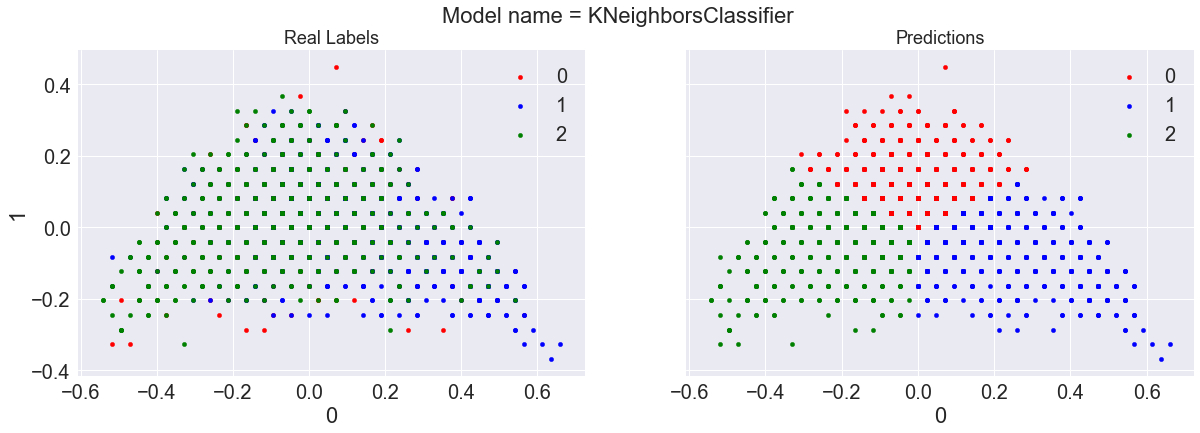

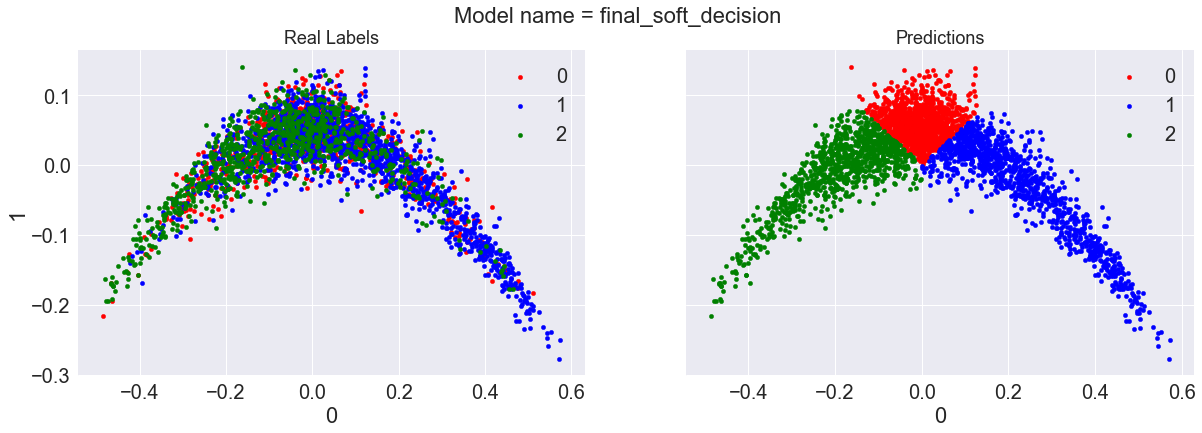

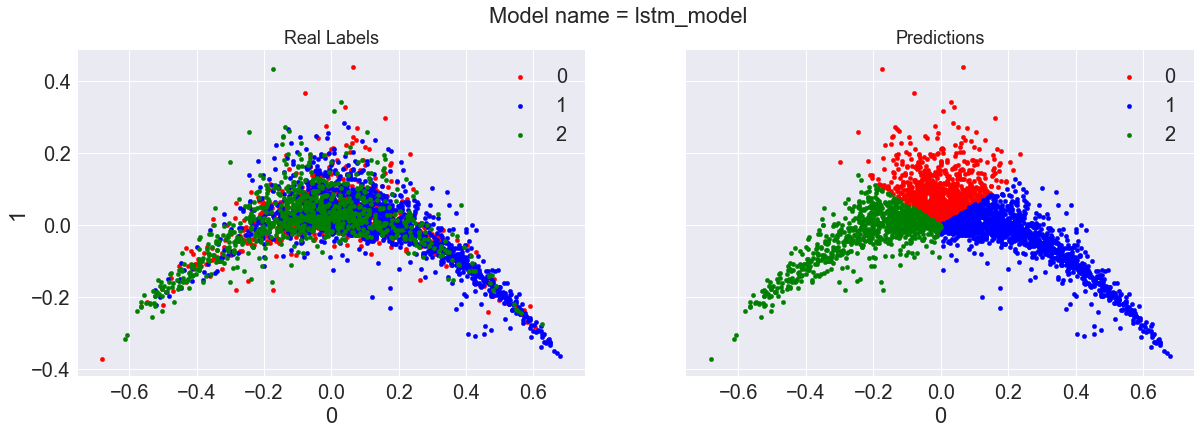

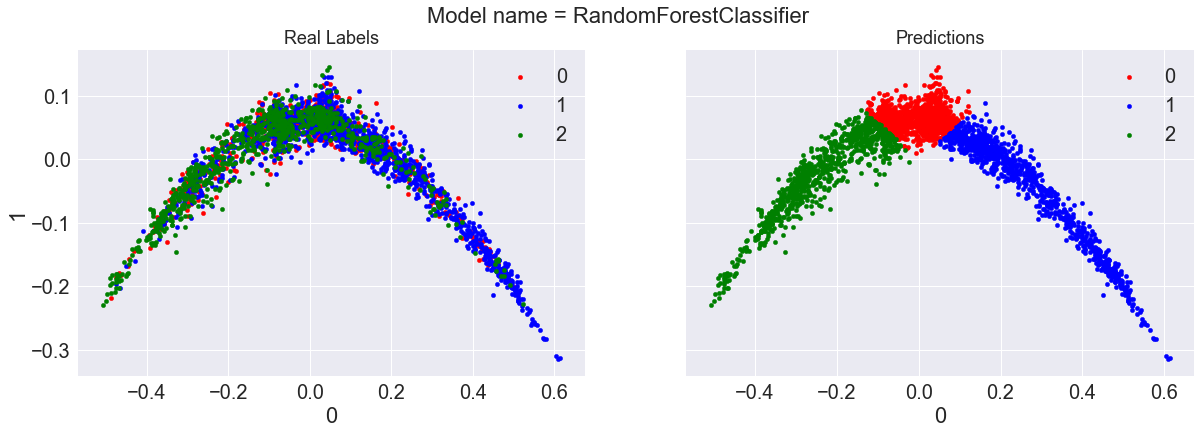

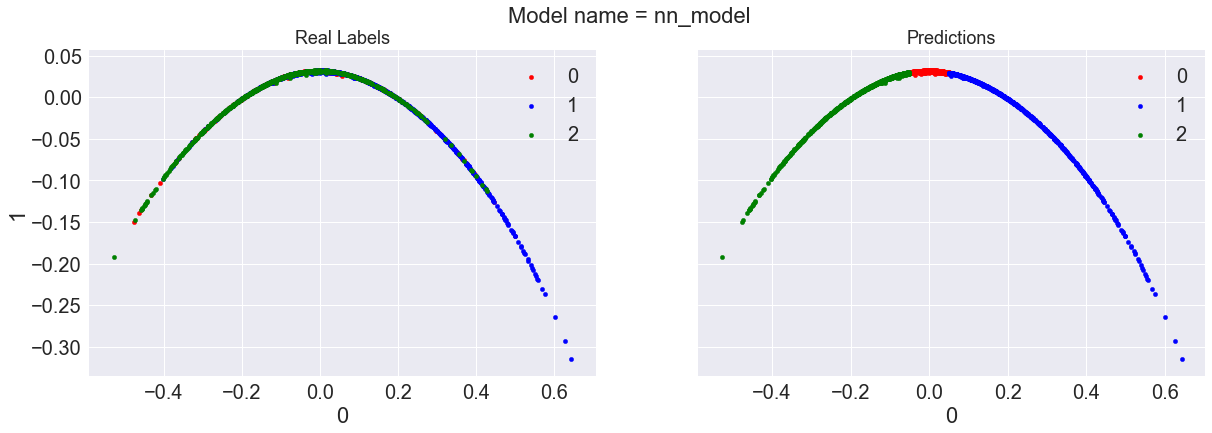

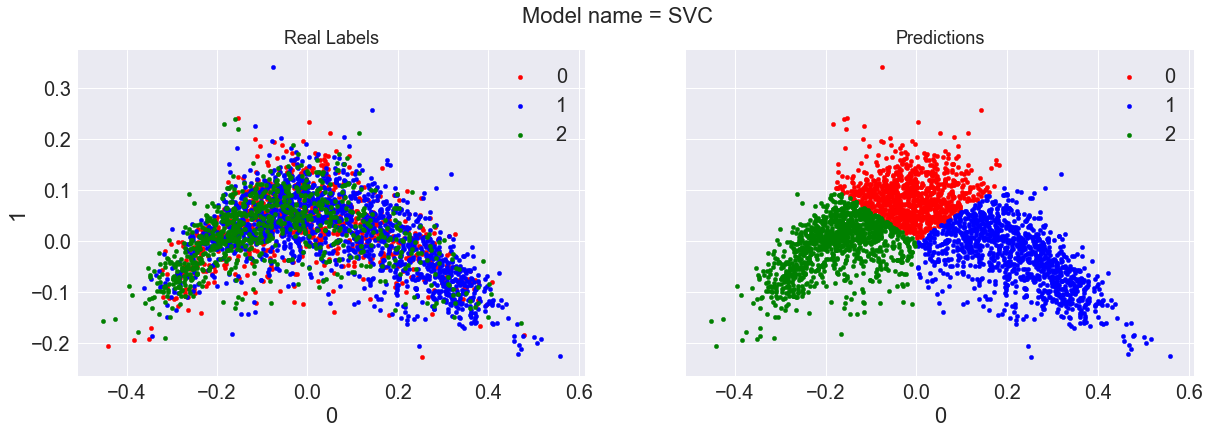

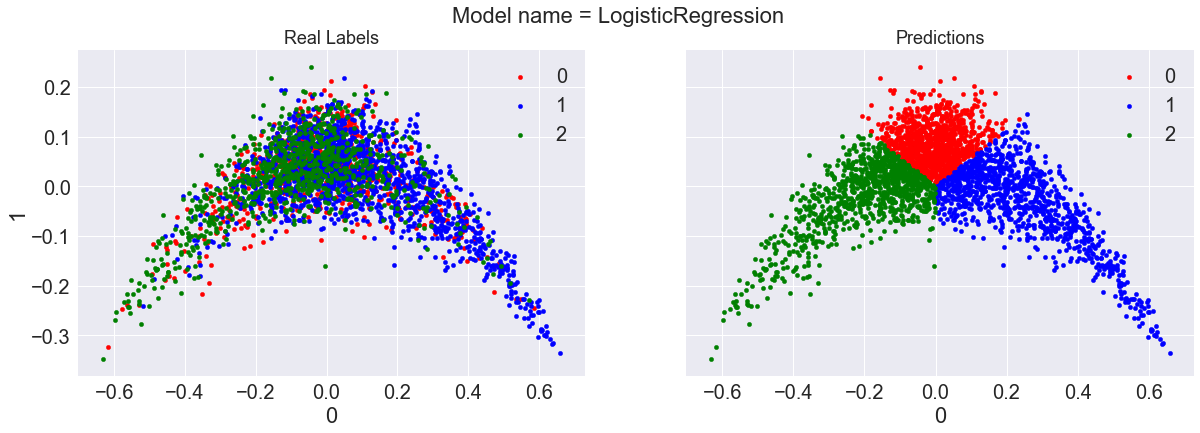

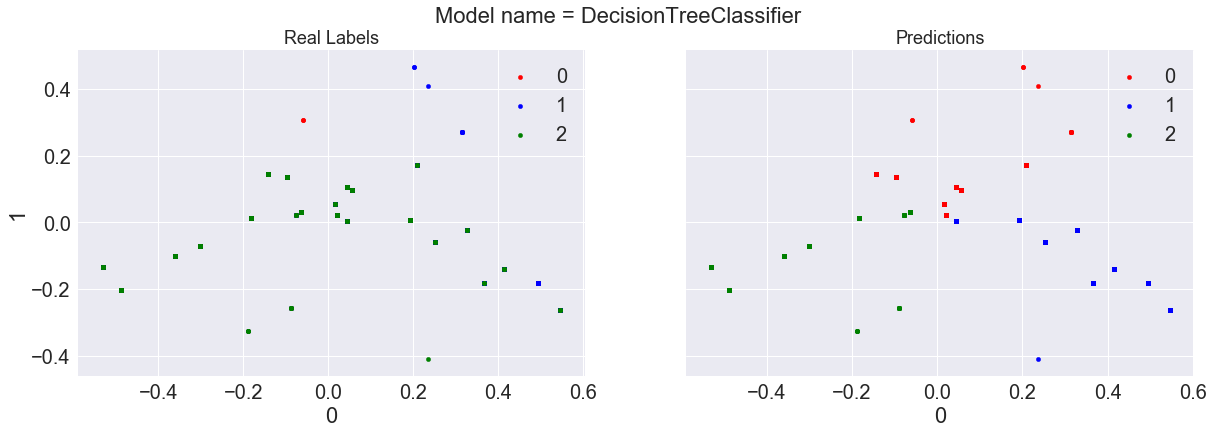

In [115]:
for model_name,model_predictions in all_soft_decisions.items():
    plot_soft_decision_plan(model_name,model_predictions,y_test_original[labels_list])

#### predictions ration:

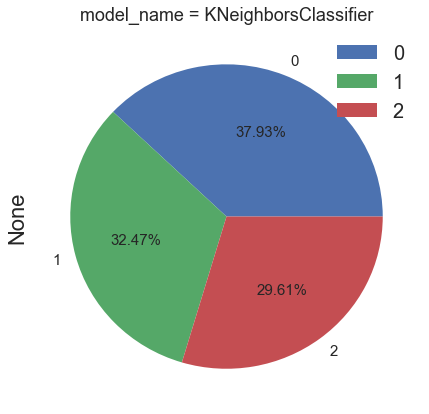

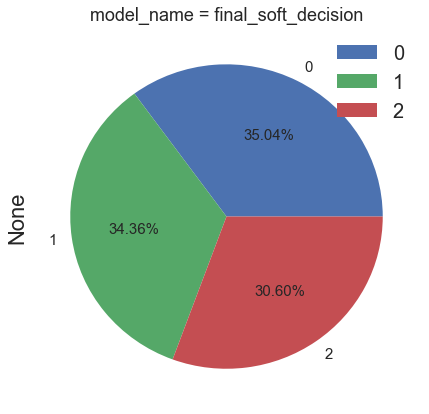

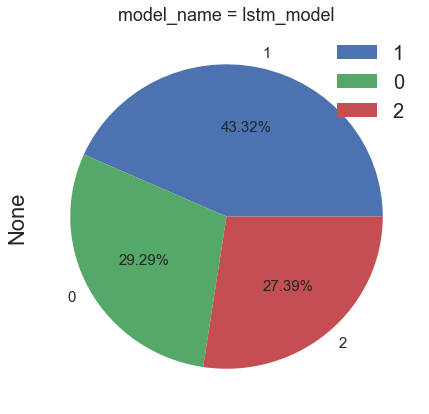

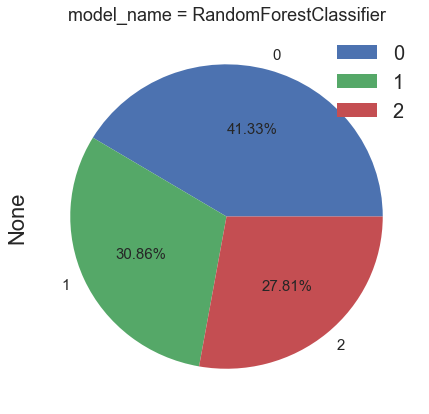

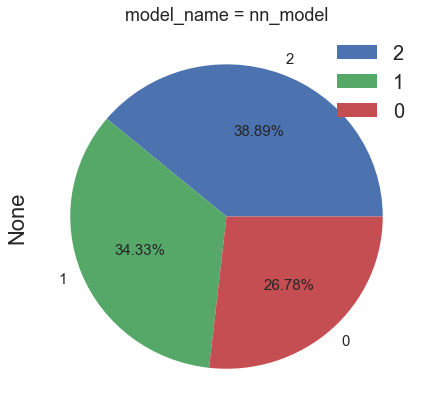

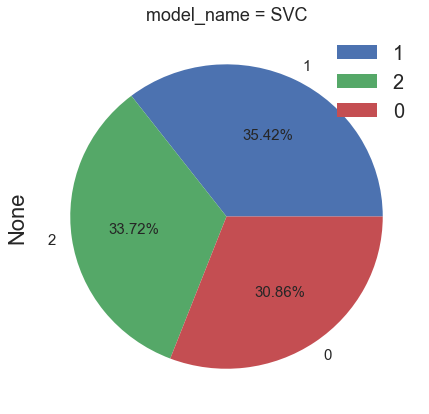

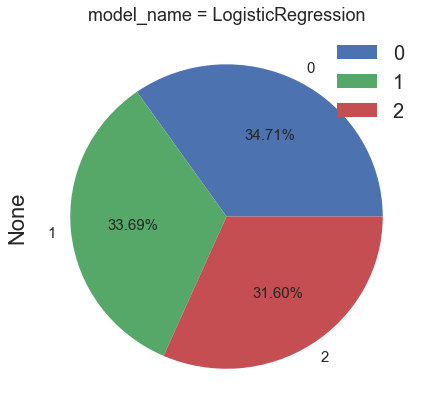

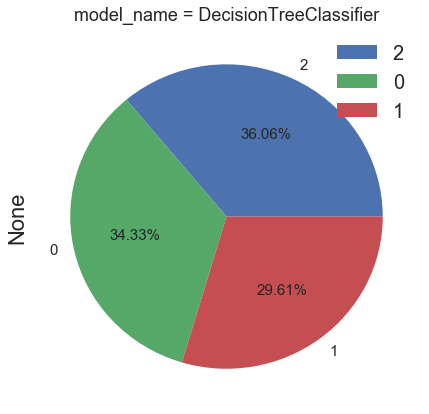

In [116]:
for model_name,model_predictions in all_soft_decisions.items():
    fig, ax = plt.subplots()
    ax.set_title("model_name = " + model_name, fontsize = 18)
    pd.Series(list(model_predictions.argmax(axis=1))).value_counts().plot.pie(figsize=(7, 7),legend=True,autopct='%.2f%%',fontsize=15)

#### Visualizing the learnt desicion tree:

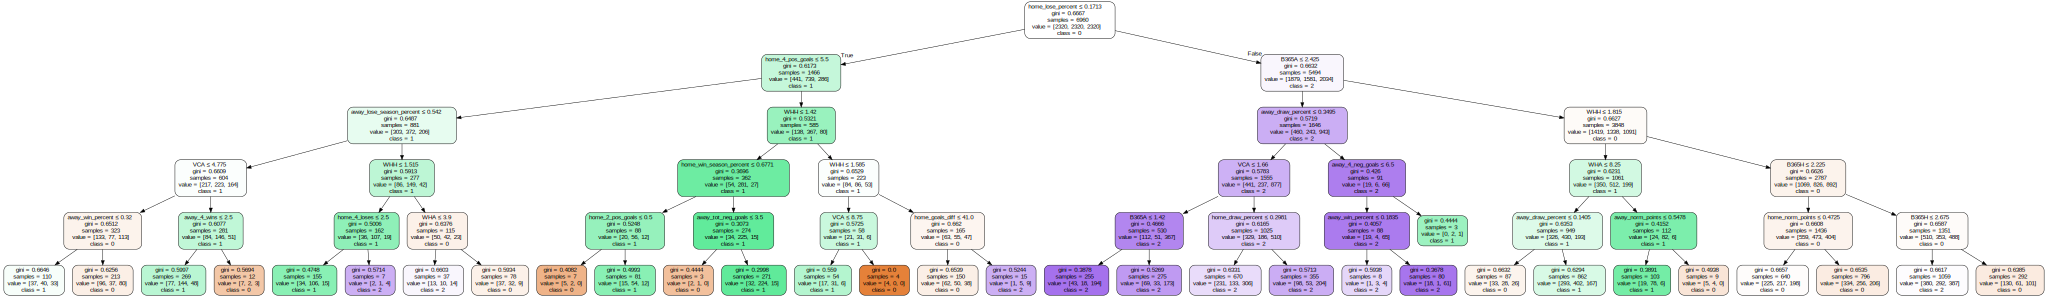

In [117]:
import graphviz 
from sklearn import tree
dot_data = tree.export_graphviz(dtree, out_file=None,feature_names=features_list,  
                                class_names=["0","1","2"],filled=True, rounded=True,special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

#### Visualizing the learnt Random forest model:

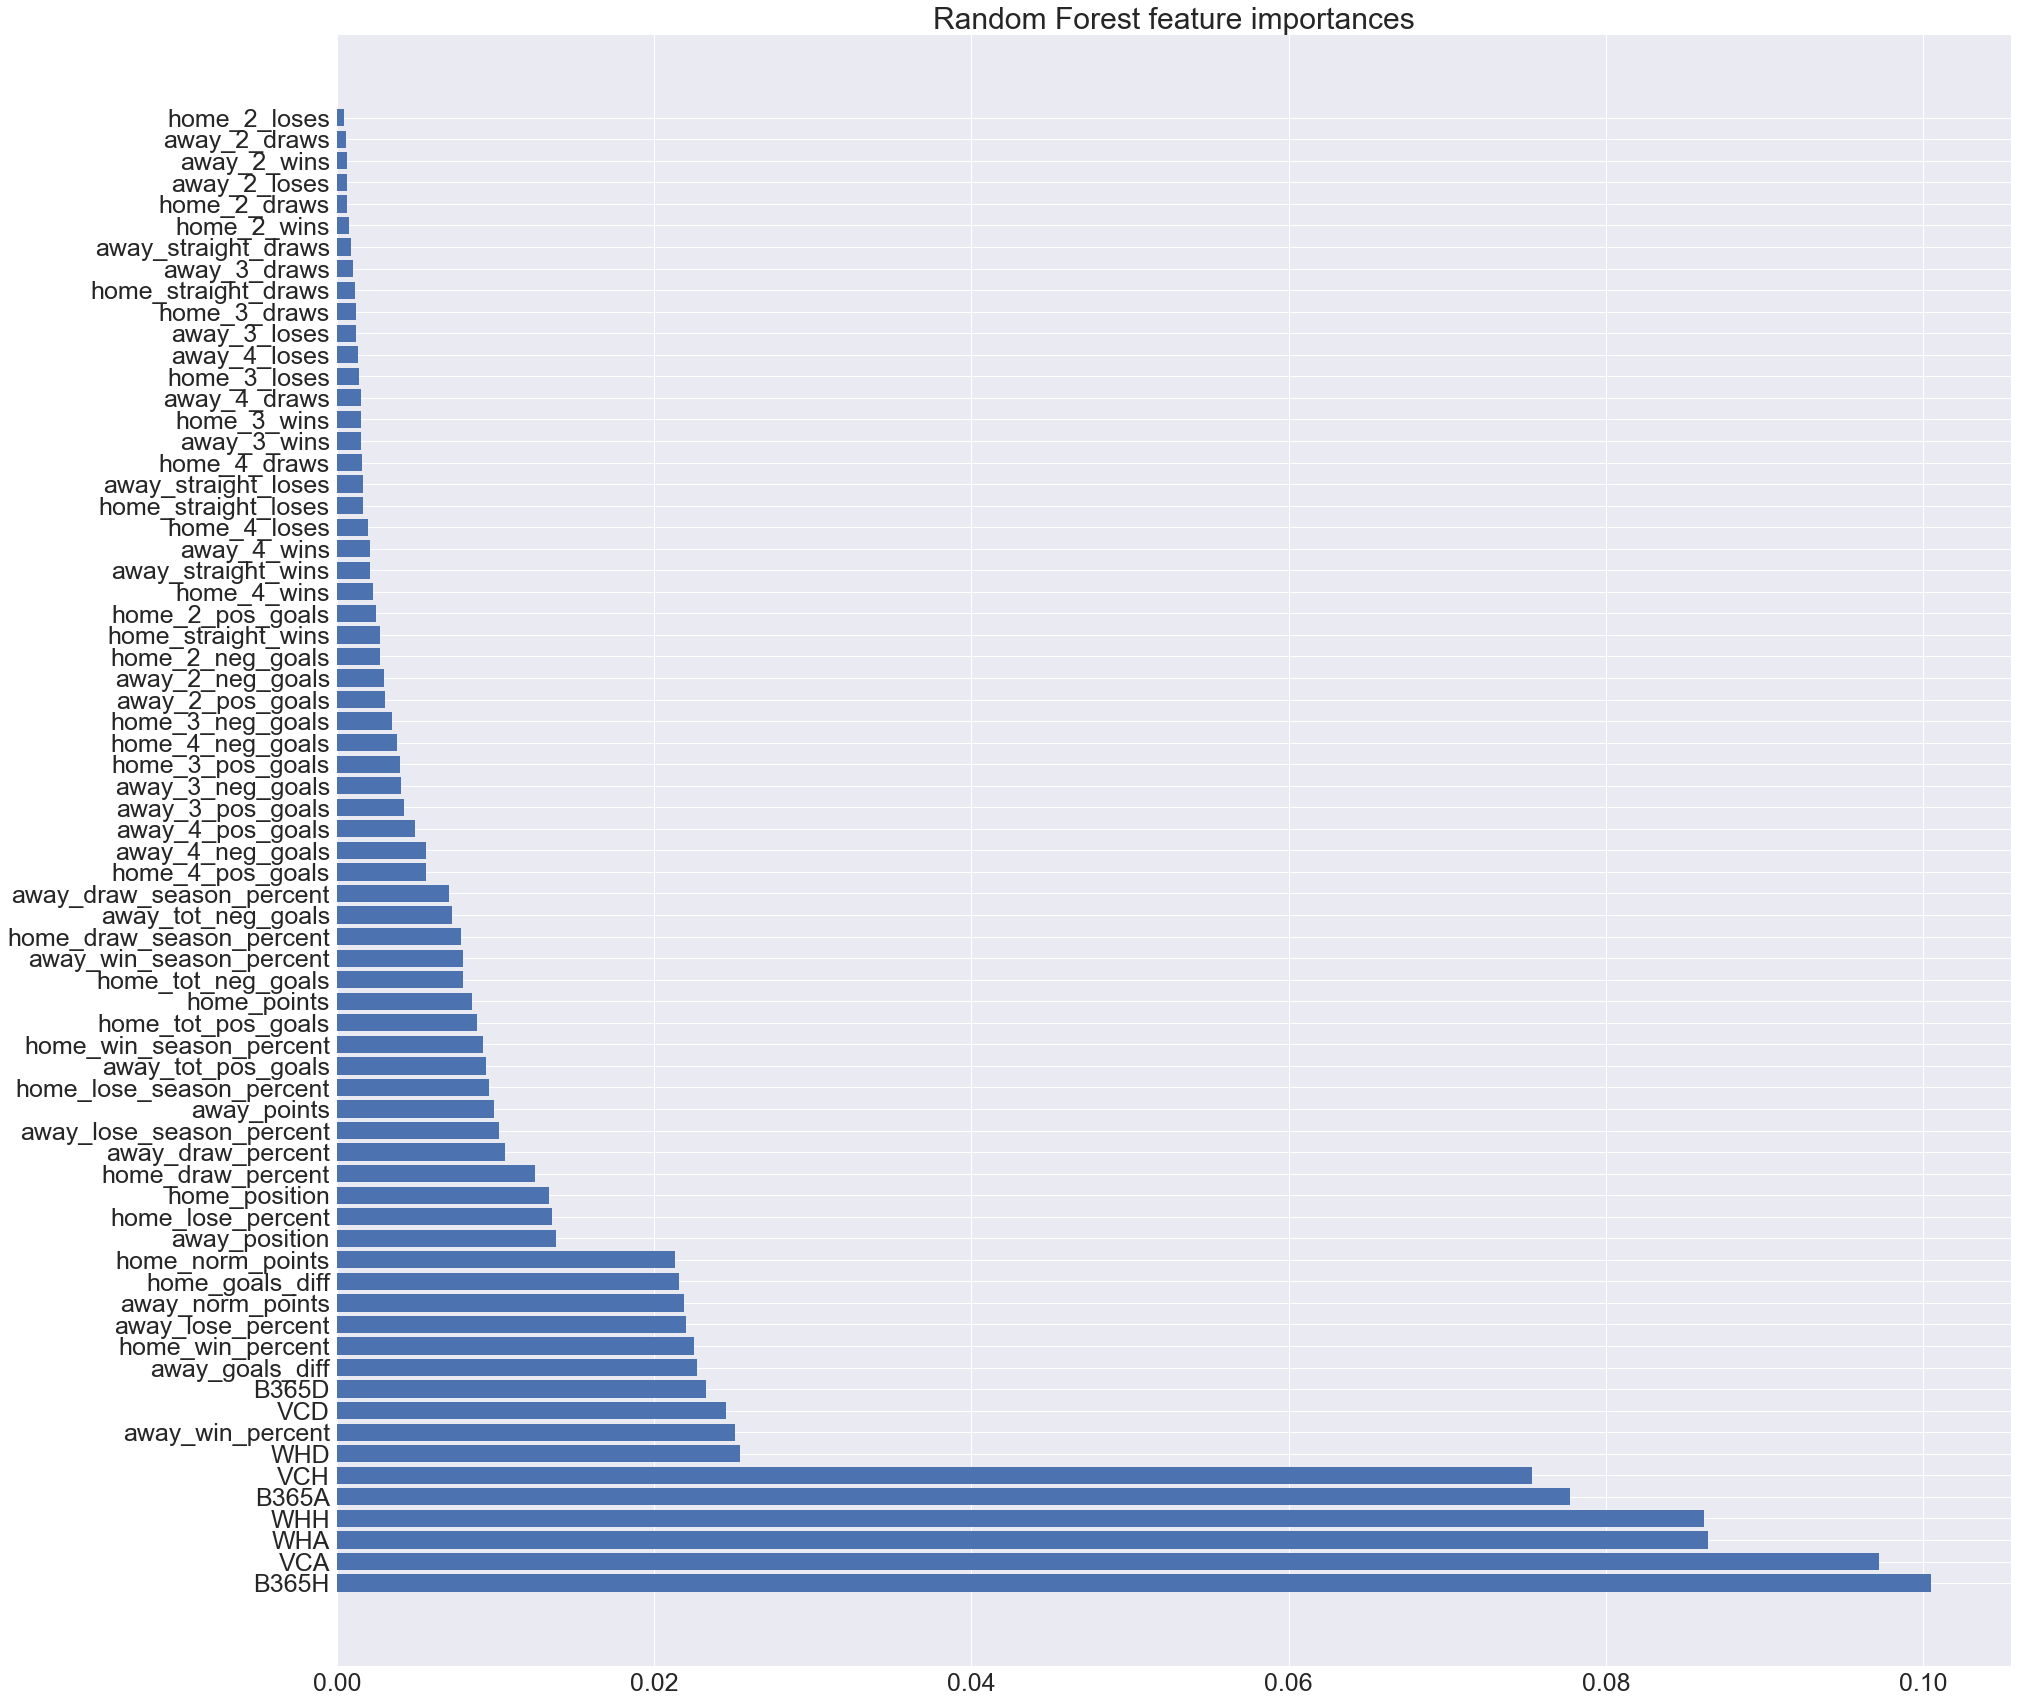

In [118]:
plt.figure(figsize=(30,30))
sort_idx = np.argsort(rfc.feature_importances_)
sort_idx = sort_idx[::-1]
rfc_sort_features_list = [features_list[ii] for ii in sort_idx ]
rects1 = plt.barh(np.arange(len(features_list)), rfc.feature_importances_[sort_idx],tick_label = rfc_sort_features_list )
plt.title('Random Forest feature importances',fontdict= {'fontsize': 30})
plt.tick_params(labelsize = 25)

#### Visualizing the learnt logistic model:

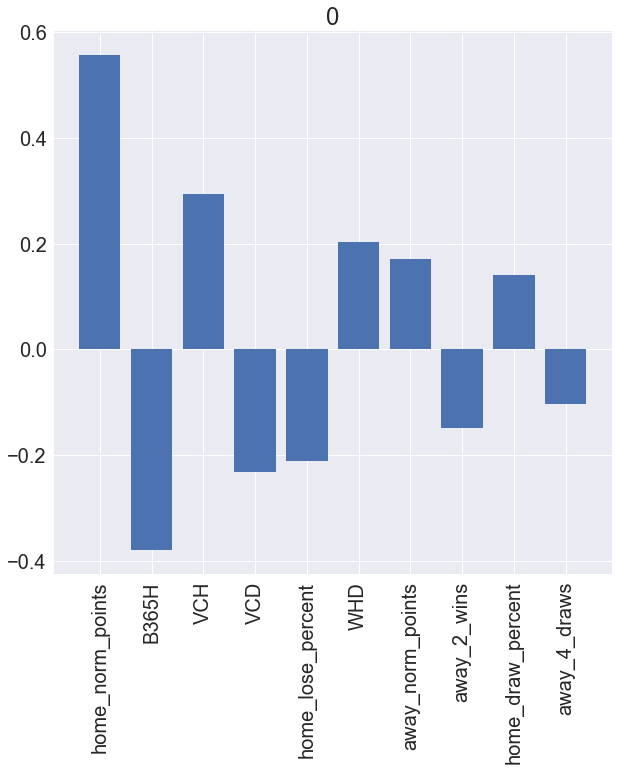

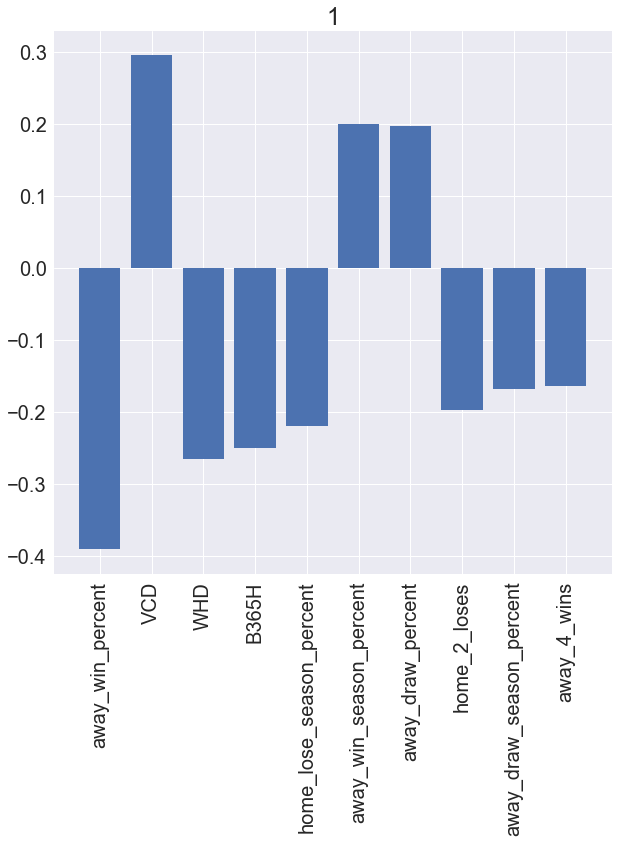

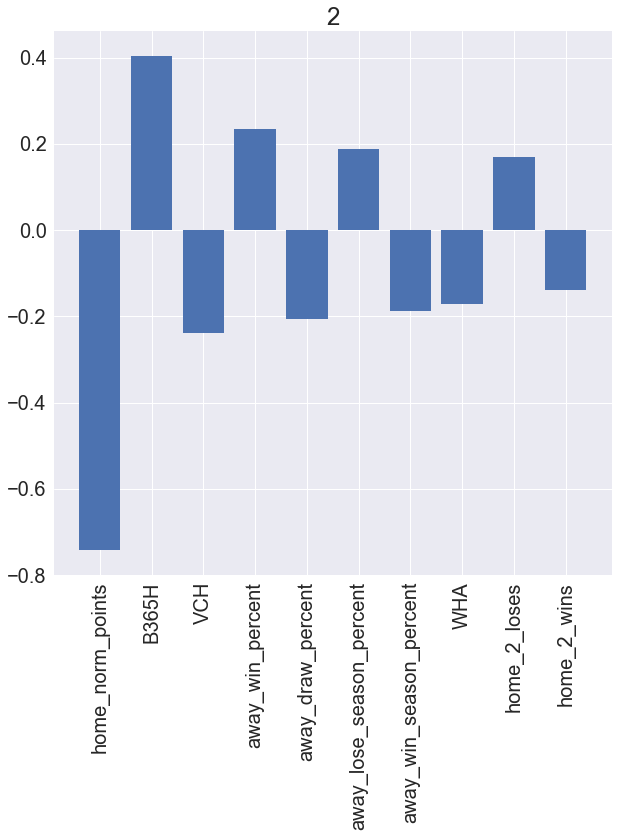

In [119]:
sns.set(font_scale=2)
df =pd.DataFrame(np.concatenate((logmodel.coef_.T,np.abs(logmodel.coef_.T)),axis=1),index=features_list ,columns=["0","1","2","0_abs","1_abs","2_abs"])
df.reset_index(inplace=True)

num_of_intresting_feat = 10

for cc in ["0_abs","1_abs","2_abs"]:
    df.sort_values(by=cc,ascending=False,inplace=True)
    plt.figure(figsize=(10,10))
    plt.bar(np.arange(num_of_intresting_feat), np.array(df.head(num_of_intresting_feat)[cc[0]]),tick_label = list(df.head(num_of_intresting_feat)["index"]))
    locs,labels = plt.xticks()
    plt.setp(labels, rotation=90)
    plt.title(cc[0])